In [56]:
import pandas as pd 
import numpy as np
import glob
import os
import math
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import pingouin as pg
import semopy
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import f_oneway, kruskal
import seaborn as sns
from statsmodels.stats.inter_rater import fleiss_kappa

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [57]:
# Read CSV
tam_df = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/tam_results/tam.csv')
demographics = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/demographic_results/demographics_processed.csv')

In [58]:
# Merge
tam_df = pd.merge(tam_df, demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Move columns 
col = tam_df.pop('q28')
tam_df.insert(23, col.name, col)
col = tam_df.pop('q29')
tam_df.insert(24, col.name, col)
# Update column names
tam_df.columns = ['user_id',
 'user_archetype',
 'ai_attitude',
 'PU1',
 'PU2',
 'PU3',
 'PU4',
 'PU5',
 'PU6',
 'PU7',
 'PU8',
 'PEOU1',
 'PU9',
 'PEOU2',
 'SE1',
 'SE2',
 'voluntary',
 'SN1',
 'SN2',
 'prestige_image',
 'PU10',
 'PU11',
 'BC1',
 'BC2',
 'BC3',
 'clinical_workflow',
 'infrastructure',
 'intention',
 'colleagues',
 'PU12',
 'final_comments',
 'age_new',
 'sex_new',
 'medical_speciality_new',
 'grade_new',
 'ai_familiarity_new']

# Get result columns 
tam_df_results = tam_df.iloc[:,2:30]

# PU

In [59]:
# PU
pu_df = tam_df_results.filter(regex='PU')
# Mean and std
pu_df.mean().mean()
pu_df.std().mean()

3.5876068376068386

0.8314373405469078

In [10]:
# Corrected item-total correlation
item_total_corr = pu_df.apply(lambda x: x.corr(pu_df.drop(columns=x.name).sum(axis=1)))
print(f"Item-Total Correlations for pu_df:\n", item_total_corr)

Item-Total Correlations for pu_df:
 PU1     0.581348
PU2     0.403797
PU3     0.600402
PU4     0.313004
PU5     0.697178
PU6     0.637888
PU7     0.798766
PU8     0.647583
PU9     0.442408
PU10    0.476784
PU11    0.441986
PU12    0.751366
dtype: float64


In [22]:
rating_counts

,1,2,3,4,5
PU1,0,0,11,24,2
PU2,0,12,10,14,1
PU3,0,3,7,20,7
PU4,1,3,6,17,10
PU5,0,4,5,22,6
PU6,0,8,10,13,6
PU7,1,6,8,16,6
PU8,0,3,8,23,3
PU9,1,7,15,12,2
PU10,0,3,20,14,0


In [60]:
# Transpose the DataFrame to make each question a row
df_transposed = pu_df.transpose()

# Determine the rating categories, assuming ratings from 1 to 5
categories = range(1, 6)  # Adjust range if your ratings differ

# Initialize a DataFrame to store the counts
rating_counts = pd.DataFrame(index=df_transposed.index, columns=categories).fillna(0)

# Count the occurrences of each rating for each question
for index, row in df_transposed.iterrows():
    for rating in categories:
        rating_counts.loc[index, rating] = sum(row == rating)

# Calculate Fleiss' kappa
kappa = fleiss_kappa(rating_counts.iloc[:2])
print("Fleiss' Kappa:", kappa)

Fleiss' Kappa: 0.04008970348016289


In [21]:
fleiss_kappa(np.array([[1,1,1], [1,1,1]]) )

-0.49999999999999994

In [11]:
# Calculate bivariate correlations between all question pairs
correlation_matrix = pu_df.corr(method='spearman')  # Spearman for ordinal data

# Print correlation matrix (optional) - explore using heatmaps for better visualization
print("Bivariate Correlations (Spearman's rank):")
print(correlation_matrix)

Bivariate Correlations (Spearman's rank):
           PU1       PU2       PU3       PU4       PU5       PU6       PU7  \
PU1   1.000000  0.126012  0.368644  0.249325  0.558114  0.463651  0.484948   
PU2   0.126012  1.000000  0.447074  0.036869  0.154506  0.276241  0.440876   
PU3   0.368644  0.447074  1.000000  0.374683  0.587071  0.583244  0.627435   
PU4   0.249325  0.036869  0.374683  1.000000  0.340684  0.231468  0.273024   
PU5   0.558114  0.154506  0.587071  0.340684  1.000000  0.591579  0.623091   
PU6   0.463651  0.276241  0.583244  0.231468  0.591579  1.000000  0.775238   
PU7   0.484948  0.440876  0.627435  0.273024  0.623091  0.775238  1.000000   
PU8   0.157194  0.542324  0.350028  0.353725  0.473246  0.354582  0.564981   
PU9   0.319065  0.224489  0.025654  0.050040  0.225966  0.395428  0.584642   
PU10  0.387388  0.216194  0.123436  0.180386  0.376256  0.135149  0.286412   
PU11  0.518605  0.212569  0.240828  0.253957  0.314664  0.237198  0.387496   
PU12  0.659212  0.2826

In [61]:
# Create df for demographic analysis
#combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(demographics[['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Create df for demographic analysis
combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(tam_df['user_id'])
combined_pu_df = combined_pu_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_pu_df['age_new'].fillna(combined_pu_df['age_new'].mode()[0], inplace=True)
combined_pu_df['sex_new'].fillna(combined_pu_df['sex_new'].mode()[0], inplace=True)
combined_pu_df['medical_speciality_new'].fillna(combined_pu_df['medical_speciality_new'].mode()[0], inplace=True)
combined_pu_df['grade_new'].fillna(combined_pu_df['grade_new'].mode()[0], inplace=True)
combined_pu_df['ai_familiarity_new'].fillna(combined_pu_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_pu_df.drop(columns='user_id', inplace=True)

In [29]:
combined_pu_df

,pu_mean,user_archetype,age_new,sex_new,medical_speciality_new,grade_new,ai_familiarity_new
0,4.166667,a,30s,Male,Pharmacist,Other,Slightly familiar
1,3.833333,b,30s,Male,Infectious Diseases,Other,Slightly familiar
2,3.500000,a,30s,Male,Infectious Diseases,Other,Slightly familiar
3,3.833333,b,30s,Female,Infectious Diseases,Other,Not familiar
4,3.666667,a,30s,Male,Other,Consultant,Slightly familiar
5,2.833333,b,40s,Male,Other,Consultant,Moderately familiar
6,4.083333,a,40s,Male,Pharmacist,Consultant,Slightly familiar
7,3.583333,b,30s,Female,Pharmacist,Other,Moderately familiar
8,3.500000,a,30s,Female,Pharmacist,Other,Slightly familiar
9,2.750000,b,40s,Male,Microbiology,Consultant,Slightly familiar


In [63]:
# Test for normality
model = smf.ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
stats.normaltest(model.resid)
stats.kstest(model.resid, 'norm')

# Test for vairance
# Levene's Test for user_archetype
levene_archetype_stat, levene_archetype_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'a'],
                       combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'b'])
print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
# Levene's Test for age_new
unique_ages = combined_pu_df['age_new'].unique()
grouped_ages = [combined_pu_df['pu_mean'][combined_pu_df['age_new'] == age] for age in unique_ages]
levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
# Levene's Test for sex_new
levene_sex_stat, levene_sex_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Male'],
                       combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Female'])
print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
# Levene's Test for medical_speciality_new
unique_medical_specialities = combined_pu_df['medical_speciality_new'].unique()
grouped_medical_specialities = [combined_pu_df['pu_mean'][combined_pu_df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
# Levene's Test for grade_new
unique_grades = combined_pu_df['grade_new'].unique()
grouped_grades = [combined_pu_df['pu_mean'][combined_pu_df['grade_new'] == grade] for grade in unique_grades]
levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
# Levene's Test for ai_familiarity_new
unique_ais = combined_pu_df['ai_familiarity_new'].unique()
grouped_ais = [combined_pu_df['pu_mean'][combined_pu_df['ai_familiarity_new'] == ai] for ai in unique_ais]
levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
    anova_bool = True
else:
    anova_bool = False

print('\n')
print('anova_bool:', anova_bool)
print('\n')

# Perform the appropriate test
# Do anover independantly for each variable and collectivly 
if anova_bool:
    print('Collective')
    model = ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    # Interpretation
    for index, row in aov_table.iterrows():
        sum_sq, df_value, f_value, pr_f = row
        print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
        if pr_f < 0.05:
            print(f"  -> The differences in {index} are statistically significant.\n")
        else:
            print(f"  -> The differences in {index} are not statistically significant.\n")

# Function to perform ANOVA
def perform_anova(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = f_oneway(*groups)
    return stat, p_value

# Function to perform Kruskal-Wallis H test
def perform_kruskal(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = kruskal(*groups)
    return stat, p_value

print('\nIndependant')
independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
results = {}
for var in independent_vars:
    if anova_bool:
        stat, p_value = perform_anova(combined_pu_df, var)
        test_name = 'ANOVA'
    else:
        stat, p_value = perform_kruskal(combined_pu_df, var)
        test_name = 'Kruskal-Wallis'
    results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

# Print the results
for var, result in results.items():
    print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print(f"  -> The differences in {var} are statistically significant.\n")
    else:
        print(f"  -> The differences in {var} are ***not*** statistically significant.\n")

Shapiro test: W-statistic=0.9801740050315857, p-value=0.7098985314369202


NormaltestResult(statistic=1.0846636606721487, pvalue=0.5813909654172728)

KstestResult(statistic=0.26597319958681565, pvalue=0.006327170293625839, statistic_location=0.5486750805604359, statistic_sign=1)

Levene's test for user_archetype: W-statistic=0.26843776265644176, p-value=0.6074661963519832
Levene's test for age_new: W-statistic=1.2020680885240043, p-value=0.3278440298592749
Levene's test for sex_new: W-statistic=0.21993006993006955, p-value=0.6418448187521716
Levene's test for medical_speciality_new: W-statistic=0.03557757454697066, p-value=0.9908511540446955
Levene's test for grade_new: W-statistic=5.047102159175517, p-value=0.03072133937695284
Levene's test for ai_familiarity_new: W-statistic=0.373359688134848, p-value=0.7727176099541755


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0241, p-value=0.8767
  -> The differences in user_archetype are ***not*** statistically significant.

Kruskal-Wallis for age_new: Statistic=4.3718, p-value=0.3580
  -> The differences in age_new are ***not*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.4230, p-value=0.5155
  -> The differences in sex_new are ***not*** statistically signifi

Text(0.5, 1.0, 'Probability plot of regression residuals \n with R value')

<bound method Axes.set of <Axes: title={'center': 'Probability plot of regression residuals \n with R value'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>>

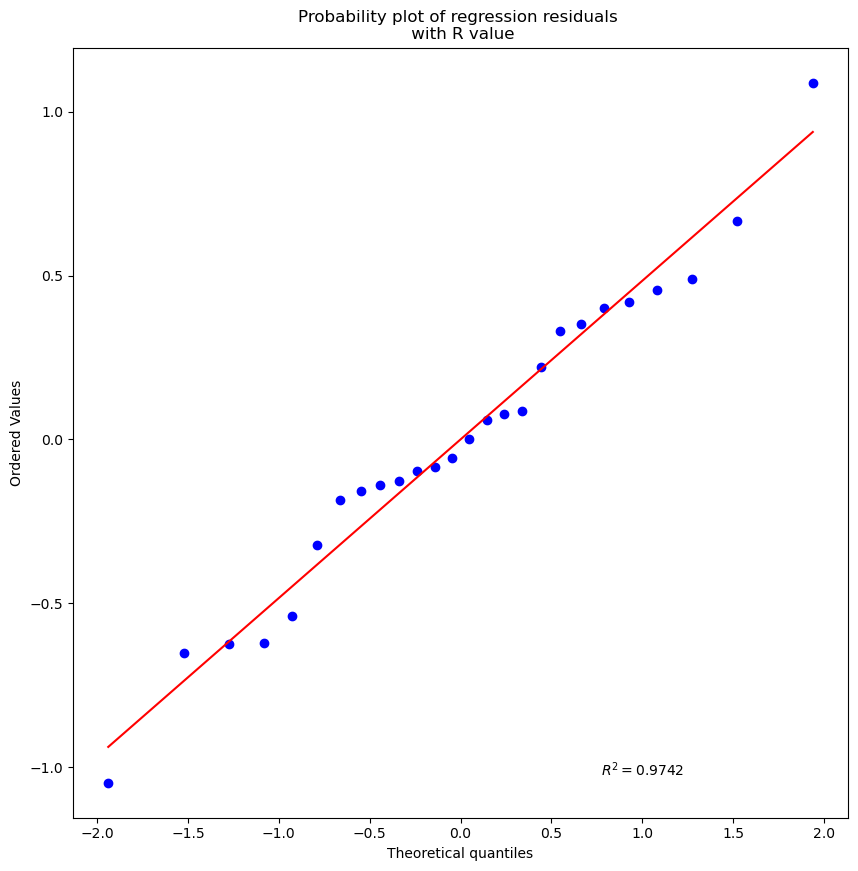

In [45]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

plt.show()

In [64]:
def plot_boxplot_with_mean_median(df, cat_col, cont_col):
    plt.figure(figsize=(10, 6))
    box_plot = sns.boxplot(
        x=cat_col, y=cont_col, data=df, showmeans=True,
        boxprops=dict(facecolor="lightblue", color="lightblue"),
        whiskerprops=dict(color="black"),
        capprops=dict(color="black"),
        flierprops=dict(markerfacecolor="black", markeredgecolor="black"),
        medianprops={"color": "darkblue", "linewidth": 2},
        meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
    )

    # Add legend
    handles = [
        plt.Line2D([0], [0], color='darkblue', lw=2, label='Median'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=10, label='Mean')
    ]
    box_plot.legend(handles=handles, loc='lower right')

    plt.xlabel(cat_col.replace('_', ' ').title())
    plt.ylabel(cont_col.replace('_', ' ').title())
    plt.title(f'Box Plot of {cont_col.replace("_", " ").title()} by {cat_col.replace("_", " ").title()}')
    plt.xticks(rotation=45)
    plt.ylim(1, 5)
    plt.show()

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


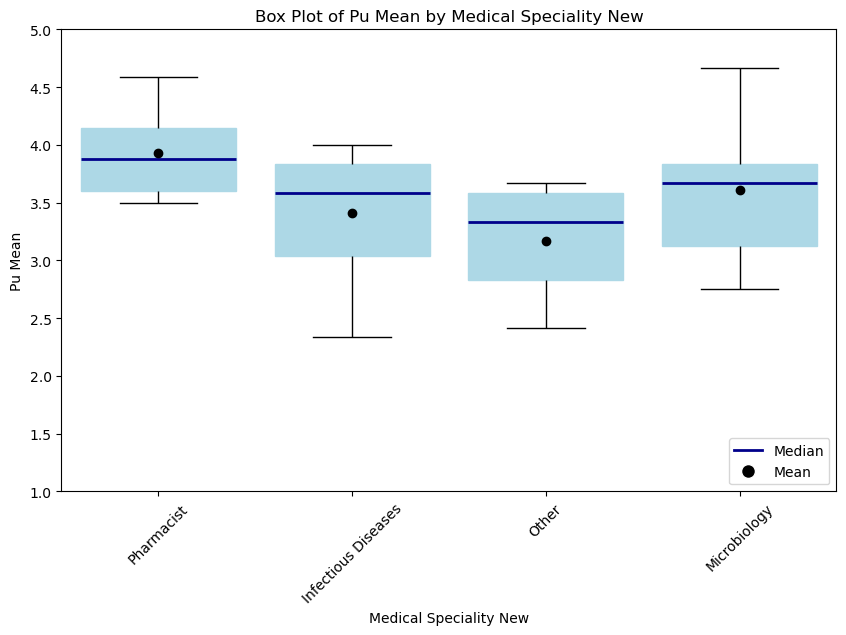

In [34]:
plot_boxplot_with_mean_median(combined_pu_df, 'medical_speciality_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


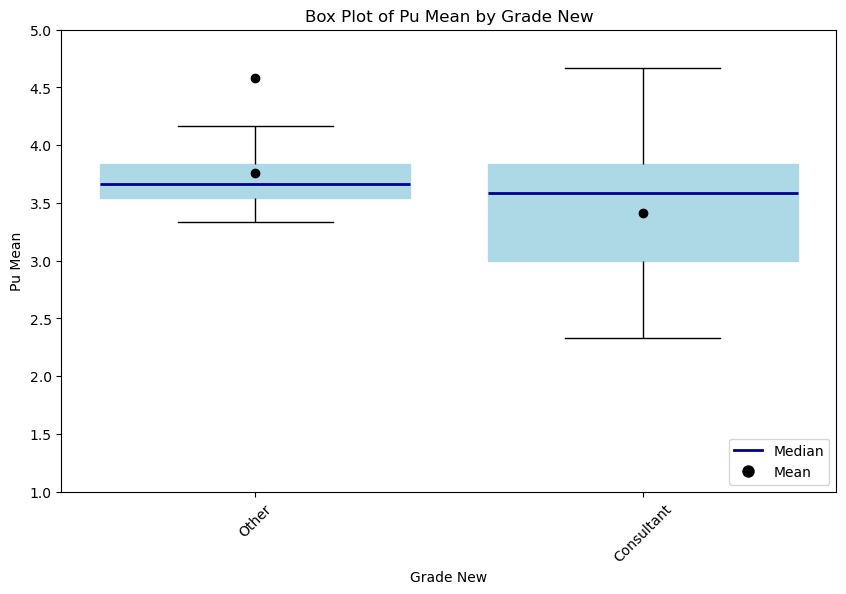

In [37]:
plot_boxplot_with_mean_median(combined_pu_df, 'grade_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


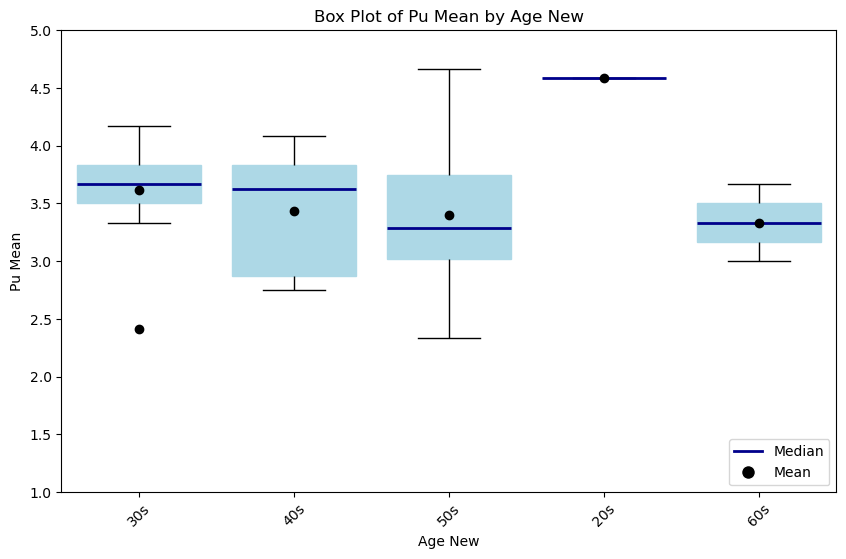

In [38]:
plot_boxplot_with_mean_median(combined_pu_df, 'age_new', 'pu_mean')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/seaborn/categorical.py:700: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  artists = ax.bxp(**boxplot_kws)


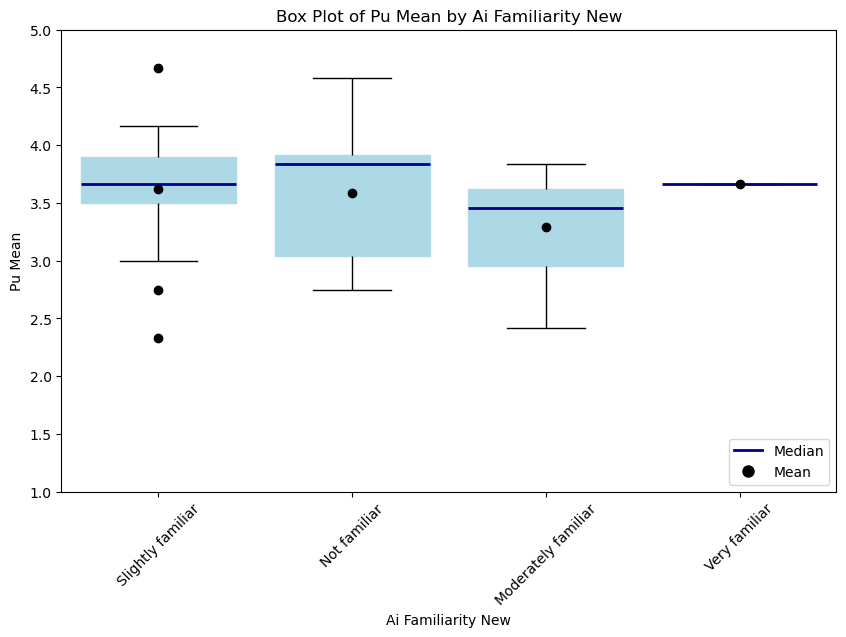

In [39]:
plot_boxplot_with_mean_median(combined_pu_df, 'ai_familiarity_new', 'pu_mean')

# Functions

In [83]:
def anover_kw_test(df, column):
    # Test for normality
    model = smf.ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
    shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
    print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
    stats.normaltest(model.resid)
    stats.kstest(model.resid, 'norm')

    # Test for vairance
    # Levene's Test for user_archetype
    levene_archetype_stat, levene_archetype_p_value = stats.levene(df[column][df['user_archetype'] == 'a'],
                        df[column][df['user_archetype'] == 'b'])
    print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
    # Levene's Test for age_new
    unique_ages = df['age_new'].unique()
    grouped_ages = [df[column][df['age_new'] == age] for age in unique_ages]
    levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
    print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
    # Levene's Test for sex_new
    levene_sex_stat, levene_sex_p_value = stats.levene(df[column][df['sex_new'] == 'Male'],
                        df[column][df['sex_new'] == 'Female'])
    print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
    # Levene's Test for medical_speciality_new
    unique_medical_specialities = df['medical_speciality_new'].unique()
    grouped_medical_specialities = [df[column][df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
    levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
    print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
    # Levene's Test for grade_new
    unique_grades = df['grade_new'].unique()
    grouped_grades = [df[column][df['grade_new'] == grade] for grade in unique_grades]
    levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
    print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
    # Levene's Test for ai_familiarity_new
    unique_ais = df['ai_familiarity_new'].unique()
    grouped_ais = [df[column][df['ai_familiarity_new'] == ai] for ai in unique_ais]
    levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
    print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

    if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
        anova_bool = True
    else:
        anova_bool = False

    print('\n')
    print('anova_bool:', anova_bool)
    print('\n')

    # Perform the appropriate test
    # Do anover independantly for each variable and collectivly 
    if anova_bool:
        print('Collective')
        model = ols(f"{column} ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=df).fit()
        aov_table = sm.stats.anova_lm(model, typ=2)
        # Interpretation
        for index, row in aov_table.iterrows():
            sum_sq, df_value, f_value, pr_f = row
            if pr_f < 0.05:
                print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
                print(f"  -> The differences in {index} are statistically significant.\n")
            #else:
            #    print(f"  -> The differences in {index} are ***NOT*** statistically significant.\n")

    # Function to perform ANOVA
    def perform_anova(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = f_oneway(*groups)
        return stat, p_value

    # Function to perform Kruskal-Wallis H test
    def perform_kruskal(df, group_var):
        groups = df.groupby(group_var)[column].apply(list)
        stat, p_value = kruskal(*groups)
        return stat, p_value

    print('\nIndependant')
    independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
    results = {}
    for var in independent_vars:
        if anova_bool:
            stat, p_value = perform_anova(df, var)
            test_name = 'ANOVA'
        else:
            stat, p_value = perform_kruskal(df, var)
            test_name = 'Kruskal-Wallis'
        results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

    # Print the results
    for var, result in results.items():
        if result['p_value'] < 0.05:
            print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
            print(f"  -> The differences in {var} are statistically significant.\n")
        #else:
        #    print(f"  -> The differences in {var} are ***NOT*** statistically significant.\n")

In [66]:
def bar_plot(df, cat_col, question='TBC'):
    # Define the mapping of numbers to labels
    labels = {1: 'Strongly disagree', 2: 'Disagree', 3: 'Neither agree nor disagree', 4: 'Agree', 5: 'Strongly agree'}

    # Map the data to the labels
    data_labels = df[cat_col].map(labels)

    # Count the occurrences of each label and convert to percentages
    label_counts = data_labels.value_counts(normalize=True).reindex(labels.values(), fill_value=0) * 100

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    bars = label_counts.plot(kind='bar', color='skyblue')
    plt.ylabel('Percentage of respondents')
    if question != 'TBC':
        plt.title(question)
    plt.xticks(rotation=45)
    plt.ylim(0, 100)  # Set the y-axis limit to 0-100%

    # Annotate bars with percentage values
    for bar in bars.patches:
        height = bar.get_height()
        plt.annotate(f'{height:.0f}%', 
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords='offset points',
                     ha='center', va='bottom')

    plt.show()

In [33]:
# Create df
updated_tam_df = tam_df.copy()
# Imputation with Mode for categorical columns
updated_tam_df['age_new'].fillna(updated_tam_df['age_new'].mode()[0], inplace=True)
updated_tam_df['sex_new'].fillna(updated_tam_df['sex_new'].mode()[0], inplace=True)
updated_tam_df['medical_speciality_new'].fillna(updated_tam_df['medical_speciality_new'].mode()[0], inplace=True)
updated_tam_df['grade_new'].fillna(updated_tam_df['grade_new'].mode()[0], inplace=True)
updated_tam_df['ai_familiarity_new'].fillna(updated_tam_df['ai_familiarity_new'].mode()[0], inplace=True)

In [8]:
updated_tam_df.columns

Index(['user_id', 'user_archetype', 'ai_attitude', 'PU1', 'PU2', 'PU3', 'PU4',
       'PU5', 'PU6', 'PU7', 'PU8', 'PEOU1', 'PU9', 'PEOU2', 'SE1', 'SE2',
       'voluntary', 'SN1', 'SN2', 'prestige_image', 'PU10', 'PU11', 'BC1',
       'BC2', 'BC3', 'clinical_workflow', 'infrastructure', 'intention',
       'colleagues', 'PU12', 'final_comments', 'age_new', 'sex_new',
       'medical_speciality_new', 'grade_new', 'ai_familiarity_new'],
      dtype='object')

# PEOU

In [67]:
# PU
peou_df = tam_df_results.filter(regex='PEOU')
# Mean and std
peou_df.mean().mean()
peou_df.std().mean()

3.8461538461538463

0.7559921648351623

In [68]:
# Create df for demographic analysis
combined_peou_df = pd.DataFrame(peou_df.mean(axis=1), columns=['peou_mean']).join(tam_df['user_id'])
combined_peou_df = combined_peou_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_peou_df['age_new'].fillna(combined_peou_df['age_new'].mode()[0], inplace=True)
combined_peou_df['sex_new'].fillna(combined_peou_df['sex_new'].mode()[0], inplace=True)
combined_peou_df['medical_speciality_new'].fillna(combined_peou_df['medical_speciality_new'].mode()[0], inplace=True)
combined_peou_df['grade_new'].fillna(combined_peou_df['grade_new'].mode()[0], inplace=True)
combined_peou_df['ai_familiarity_new'].fillna(combined_peou_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_peou_df.drop(columns='user_id', inplace=True)

In [69]:
anover_kw_test(combined_peou_df, 'peou_mean')

Shapiro test: W-statistic=0.9778116345405579, p-value=0.6242060661315918
Levene's test for user_archetype: W-statistic=0.019855129783437436, p-value=0.8887068079497477
Levene's test for age_new: W-statistic=0.5467646497423172, p-value=0.702560240903692
Levene's test for sex_new: W-statistic=1.4889960176063728, p-value=0.23009273287744816
Levene's test for medical_speciality_new: W-statistic=2.1999019763683574, p-value=0.10544503489702131
Levene's test for grade_new: W-statistic=0.09417420814479635, p-value=0.7606566088032471
Levene's test for ai_familiarity_new: W-statistic=1.0378002474508299, p-value=0.3878734983142534


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.2419, p-value=0.6271
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.5422, p-value=0.7062
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.5495, p-value=0.4654
  -> The differences i

# SE

In [70]:
# SE
se_df = tam_df_results.filter(regex='SE')
# Mean and std
se_df.mean().mean()
se_df.std().mean()

4.076923076923077

0.517230723151553

In [71]:
# Create df for demographic analysis
combined_se_df = pd.DataFrame(se_df.mean(axis=1), columns=['se_mean']).join(tam_df['user_id'])
combined_se_df = combined_se_df.merge(demographics[['user_id', 'user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])


# Imputation with Mode for categorical columns
combined_se_df['age_new'].fillna(combined_se_df['age_new'].mode()[0], inplace=True)
combined_se_df['sex_new'].fillna(combined_se_df['sex_new'].mode()[0], inplace=True)
combined_se_df['medical_speciality_new'].fillna(combined_se_df['medical_speciality_new'].mode()[0], inplace=True)
combined_se_df['grade_new'].fillna(combined_se_df['grade_new'].mode()[0], inplace=True)
combined_se_df['ai_familiarity_new'].fillna(combined_se_df['ai_familiarity_new'].mode()[0], inplace=True)

# Drop
combined_se_df.drop(columns='user_id', inplace=True)

In [72]:
anover_kw_test(combined_se_df, 'se_mean')

Shapiro test: W-statistic=0.974946141242981, p-value=0.5244541168212891
Levene's test for user_archetype: W-statistic=0.017182288848207102, p-value=0.8964212002327235
Levene's test for age_new: W-statistic=1.3579881656804735, p-value=0.2689713321959304
Levene's test for sex_new: W-statistic=0.29121628712351777, p-value=0.592675272661916
Levene's test for medical_speciality_new: W-statistic=0.3274296094459582, p-value=0.8055099686592619
Levene's test for grade_new: W-statistic=0.5473372781065086, p-value=0.46407628334385864
Levene's test for ai_familiarity_new: W-statistic=1.3585689672646195, p-value=0.2714287427855515


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.8222, p-value=0.3732
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.2394, p-value=0.9133
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.1499, p-value=0.7019
  -> The differences in 

4.0

0.3592106040535498

Shapiro test: W-statistic=0.8137879371643066, p-value=7.483569061150774e-05
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=2.9999999999999996, p-value=0.03598902422099518
Levene's test for sex_new: W-statistic=1.8028846153846152, p-value=0.18943611374765182
Levene's test for medical_speciality_new: W-statistic=1.8030303030303032, p-value=0.1695280679670223
Levene's test for grade_new: W-statistic=0.167910447761194, p-value=0.6848869490049643
Levene's test for ai_familiarity_new: W-statistic=0.5283018867924528, p-value=0.6665132259888265


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.0000, p-value=1.0000
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=1.8878, p-value=0.7564
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=0.9841, p-value=0.3212
  -> The differences i

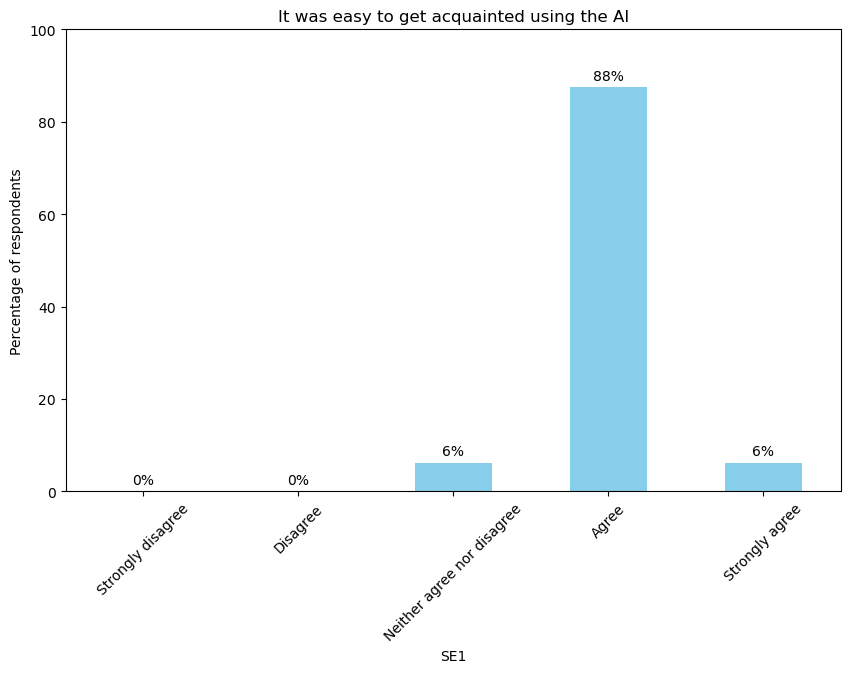

In [47]:
updated_tam_df['SE1'].mean()
updated_tam_df['SE1'].std()
anover_kw_test(updated_tam_df, 'SE1')
bar_plot(updated_tam_df, 'SE1', 'It was easy to get acquainted using the AI')

4.125

0.6090712125322324

Shapiro test: W-statistic=0.9381060600280762, p-value=0.06616336852312088
Levene's test for user_archetype: W-statistic=0.0, p-value=1.0
Levene's test for age_new: W-statistic=1.6731015358361774, p-value=0.18524981822212003
Levene's test for sex_new: W-statistic=2.8125, p-value=0.10392372192247289
Levene's test for medical_speciality_new: W-statistic=0.6970618034447821, p-value=0.5616742902506029
Levene's test for grade_new: W-statistic=0.43032786885245916, p-value=0.5168281466205649
Levene's test for ai_familiarity_new: W-statistic=1.2649812734082395, p-value=0.3054260056488501


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0965, p-value=0.7596
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.0637, p-value=0.9919
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.7256, p-value=0.4055
  -> The differences in sex_new are ***NOT*** statistically sign

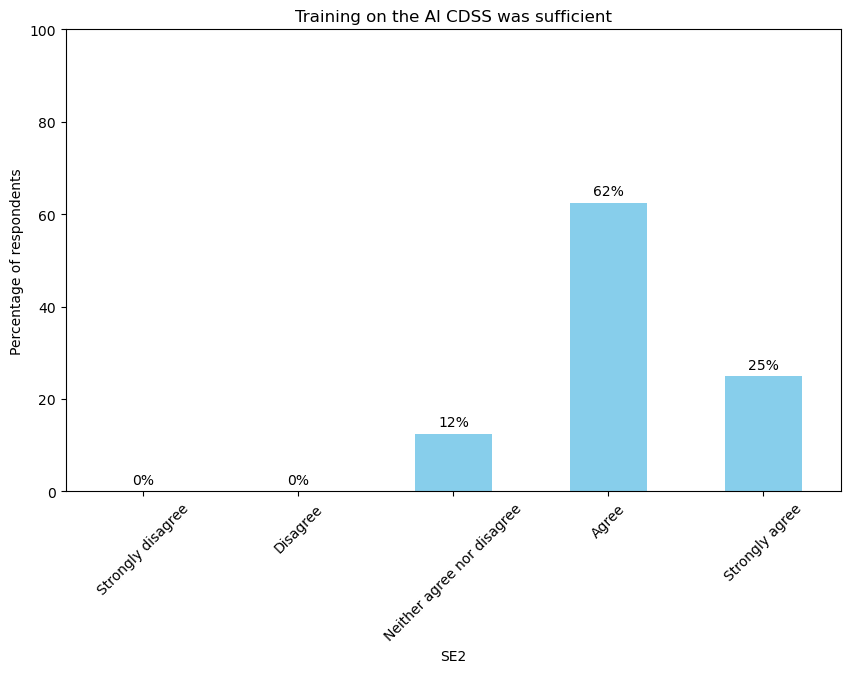

In [48]:
updated_tam_df['SE2'].mean()
updated_tam_df['SE2'].std()
anover_kw_test(updated_tam_df, 'SE2')
bar_plot(updated_tam_df, 'SE2', 'Training on the AI CDSS was sufficient')

# SN

In [73]:
# SE
sn_df = tam_df_results.filter(regex='SN')
# Mean and std
sn_df.mean().mean()
sn_df.std().mean()

3.2051282051282053

0.6273105086453568

3.289473684210526

0.5651067699567267

Shapiro test: W-statistic=0.9586696624755859, p-value=0.17178556323051453
Levene's test for user_archetype: W-statistic=0.08999999999999998, p-value=0.7659026536659794
Levene's test for age_new: W-statistic=0.4608142347115052, p-value=0.7638869273062916
Levene's test for sex_new: W-statistic=0.012326354920759203, p-value=0.9122139066581394
Levene's test for medical_speciality_new: W-statistic=0.24443824216979318, p-value=0.864695967991773
Levene's test for grade_new: W-statistic=0.24208733076302344, p-value=0.62568967016363
Levene's test for ai_familiarity_new: W-statistic=0.1940393151553583, p-value=0.8997289654608489


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0525, p-value=0.8207
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=1.6337, p-value=0.1983
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=0.0001, p-value=0.9933
  -> The differences in

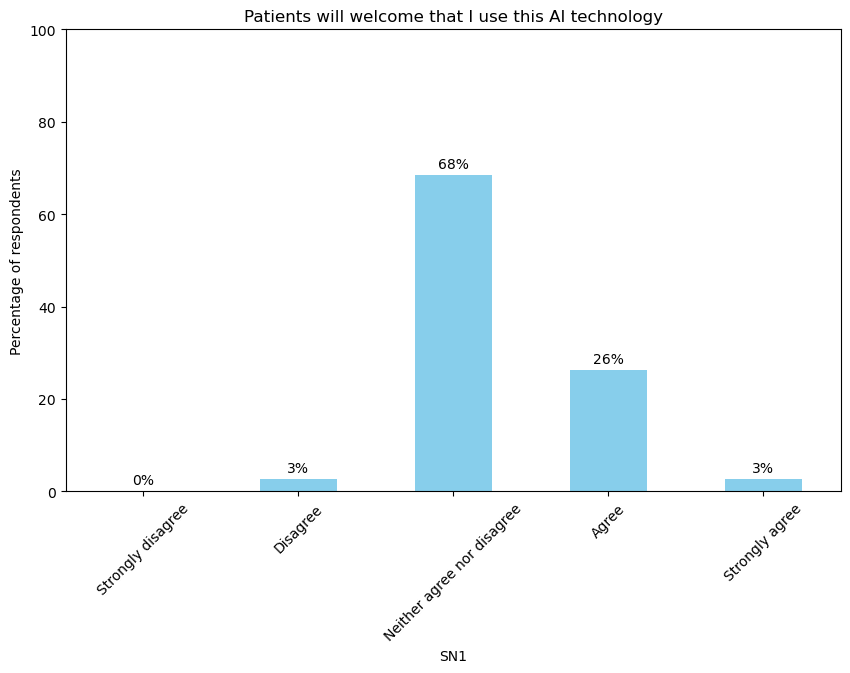

In [74]:
updated_tam_df['SN1'].mean()
updated_tam_df['SN1'].std()
anover_kw_test(updated_tam_df, 'SN1')
bar_plot(updated_tam_df, 'SN1', 'Patients will welcome that I use this AI technology')

3.125

0.7513428837969107

Shapiro test: W-statistic=0.965495765209198, p-value=0.3851791024208069
Levene's test for user_archetype: W-statistic=7.5, p-value=0.010279820529200292
Levene's test for age_new: W-statistic=0.27295703454085923, p-value=0.8928204737838561
Levene's test for sex_new: W-statistic=0.38585209003215465, p-value=0.5391793540145631
Levene's test for medical_speciality_new: W-statistic=0.3457933620024257, p-value=0.792422547119019
Levene's test for grade_new: W-statistic=0.10425716768027816, p-value=0.7490192548058903
Levene's test for ai_familiarity_new: W-statistic=0.943458251150559, p-value=0.4329118032392627


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=0.1736, p-value=0.6770
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=6.8868, p-value=0.1420
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=3.1104, p-value=0.0778
  -> The 

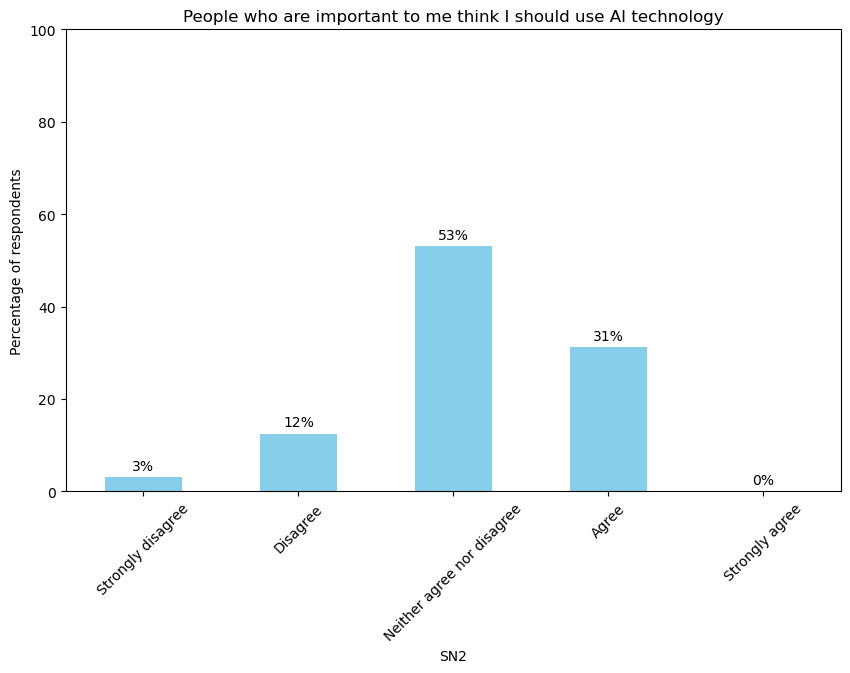

In [52]:
updated_tam_df['SN2'].mean()
updated_tam_df['SN2'].std()
anover_kw_test(updated_tam_df, 'SN2')
bar_plot(updated_tam_df, 'SN2', 'People who are important to me think I should use AI technology')

# BC

In [53]:
# BC
bc_df = tam_df_results.filter(regex='BC')
# Mean and std
bc_df.mean().mean()
bc_df.std().mean()

3.4129166666666664

0.9605826854626058

2.710526315789474

0.89768154037911

Shapiro test: W-statistic=0.9787306189537048, p-value=0.6724073886871338
Levene's test for user_archetype: W-statistic=0.23529411764705882, p-value=0.6305646187278275
Levene's test for age_new: W-statistic=0.721971348489567, p-value=0.5831447080574308
Levene's test for sex_new: W-statistic=1.4279065831782018, p-value=0.23991954978497557
Levene's test for medical_speciality_new: W-statistic=0.3167354387749753, p-value=0.8131654203578011
Levene's test for grade_new: W-statistic=0.05921052631578942, p-value=0.8091293697185452
Levene's test for ai_familiarity_new: W-statistic=0.7822835777969516, p-value=0.5121025904287679


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0226, p-value=0.8819
  -> The differences in user_archetype are ***NOT*** statistically significant.

ANOVA for age_new: Statistic=0.1816, p-value=0.9457
  -> The differences in age_new are ***NOT*** statistically significant.

ANOVA for sex_new: Statistic=3.5027, p-value=0.0735
  -> The differences in 

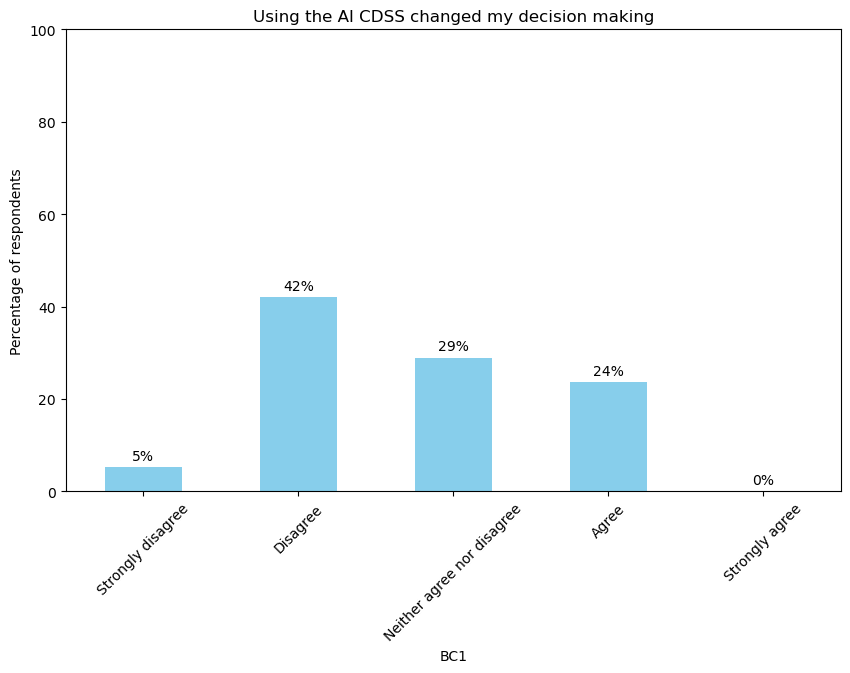

In [77]:
updated_tam_df['BC1'].mean()
updated_tam_df['BC1'].std()
anover_kw_test(updated_tam_df, 'BC1')
bar_plot(updated_tam_df, 'BC1', 'Using the AI CDSS changed my decision making')

3.870967741935484

0.8847574237748621

Shapiro test: W-statistic=0.9712966680526733, p-value=0.5554162859916687
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=nan, p-value=nan
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=nan, p-value=nan
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=nan, p-value=nan
  -> The differences in sex_new are ***NOT*** statistically significant.

Kruskal-Wallis for medical_speciality_new: Statistic=nan, p-value=nan
  -> The differences in medical_speciality_new are

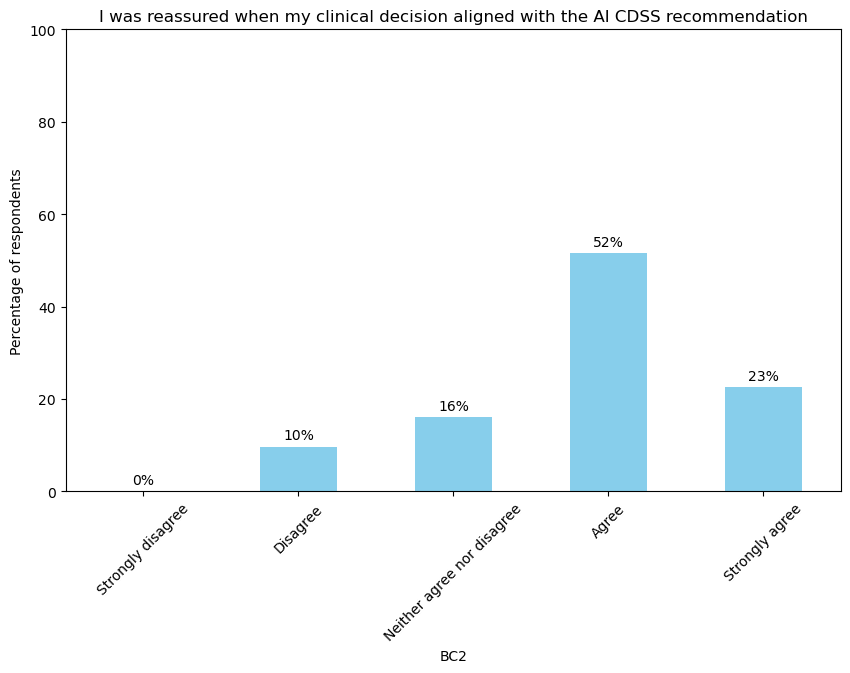

In [76]:
updated_tam_df['BC2'].mean()
updated_tam_df['BC2'].std()
anover_kw_test(updated_tam_df, 'BC2')
bar_plot(updated_tam_df, 'BC2', 'I was reassured when my clinical decision aligned with the AI CDSS recommendation')

3.6774193548387095

0.9087389347953035

Shapiro test: W-statistic=0.9429874420166016, p-value=0.09983137249946594
Levene's test for user_archetype: W-statistic=nan, p-value=nan
Levene's test for age_new: W-statistic=nan, p-value=nan
Levene's test for sex_new: W-statistic=nan, p-value=nan
Levene's test for medical_speciality_new: W-statistic=nan, p-value=nan
Levene's test for grade_new: W-statistic=nan, p-value=nan
Levene's test for ai_familiarity_new: W-statistic=nan, p-value=nan


anova_bool: False



Independant
Kruskal-Wallis for user_archetype: Statistic=nan, p-value=nan
  -> The differences in user_archetype are ***NOT*** statistically significant.

Kruskal-Wallis for age_new: Statistic=nan, p-value=nan
  -> The differences in age_new are ***NOT*** statistically significant.

Kruskal-Wallis for sex_new: Statistic=nan, p-value=nan
  -> The differences in sex_new are ***NOT*** statistically significant.

Kruskal-Wallis for medical_speciality_new: Statistic=nan, p-value=nan
  -> The differences in medical_speciality_new ar

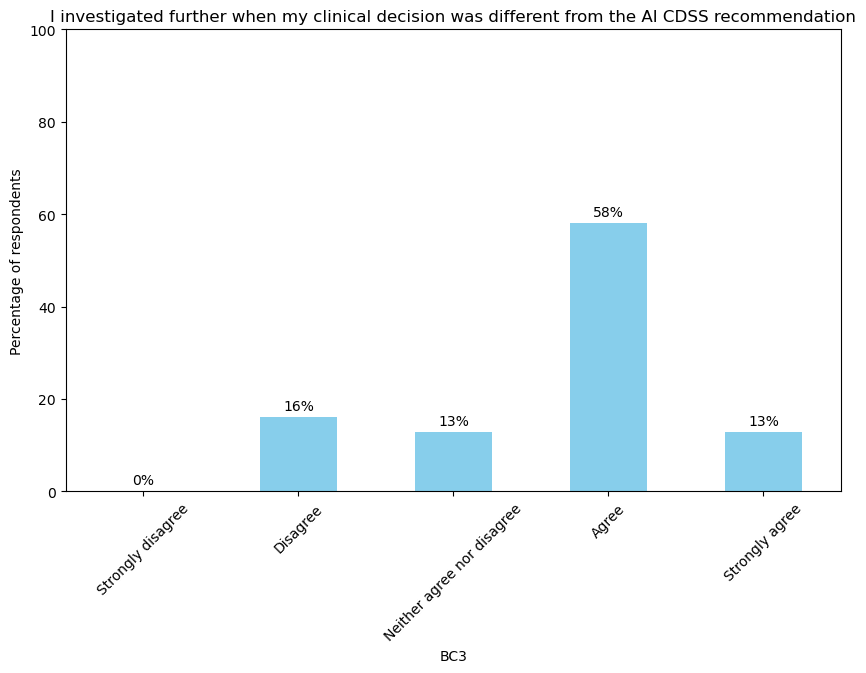

In [78]:
updated_tam_df['BC3'].mean()
updated_tam_df['BC3'].std()
anover_kw_test(updated_tam_df, 'BC3')
bar_plot(updated_tam_df, 'BC3', 'I investigated further when my clinical decision was different from the AI CDSS recommendation')

# Others

In [84]:
# ai_attitude
updated_tam_df['ai_attitude'].mean()
updated_tam_df['ai_attitude'].std()
anover_kw_test(updated_tam_df, 'ai_attitude')

3.5789473684210527

0.6830606378593979

Shapiro test: W-statistic=0.956473708152771, p-value=0.14554375410079956
Levene's test for user_archetype: W-statistic=2.347826086956522, p-value=0.13419955710253242
Levene's test for age_new: W-statistic=0.7281376518218624, p-value=0.5791524316464789
Levene's test for sex_new: W-statistic=0.22364106988783441, p-value=0.6391343000276171
Levene's test for medical_speciality_new: W-statistic=0.5748820914667935, p-value=0.6354520231441246
Levene's test for grade_new: W-statistic=0.7143358592636944, p-value=0.4035905892922277
Levene's test for ai_familiarity_new: W-statistic=0.6919298245614036, p-value=0.5633213741539786


anova_bool: True


Collective
ANOVA for grade_new: Statistic=5.8654, p-value=0.0234
  -> The differences in grade_new are statistically significant.


Independant


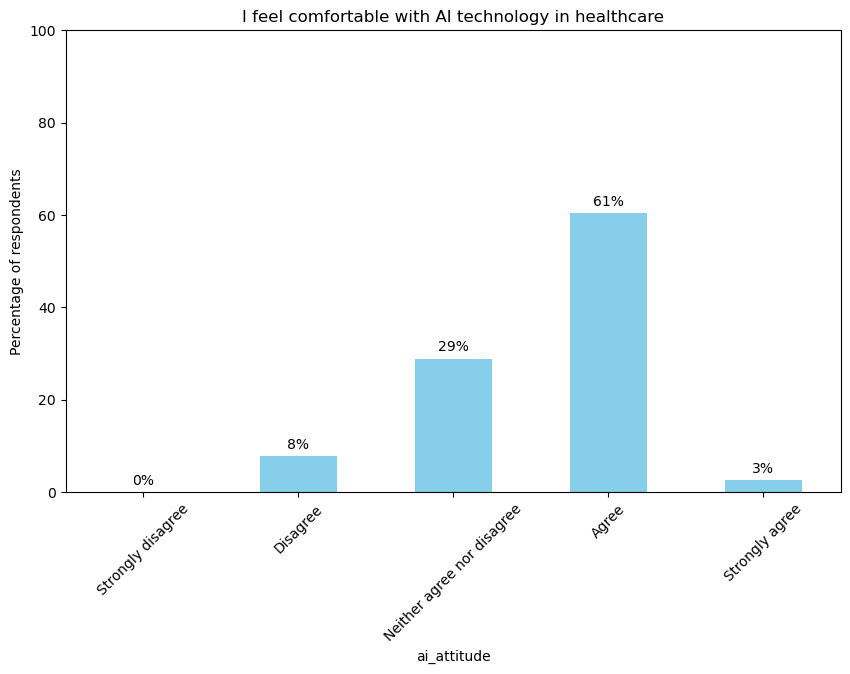

In [91]:
bar_plot(updated_tam_df, 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

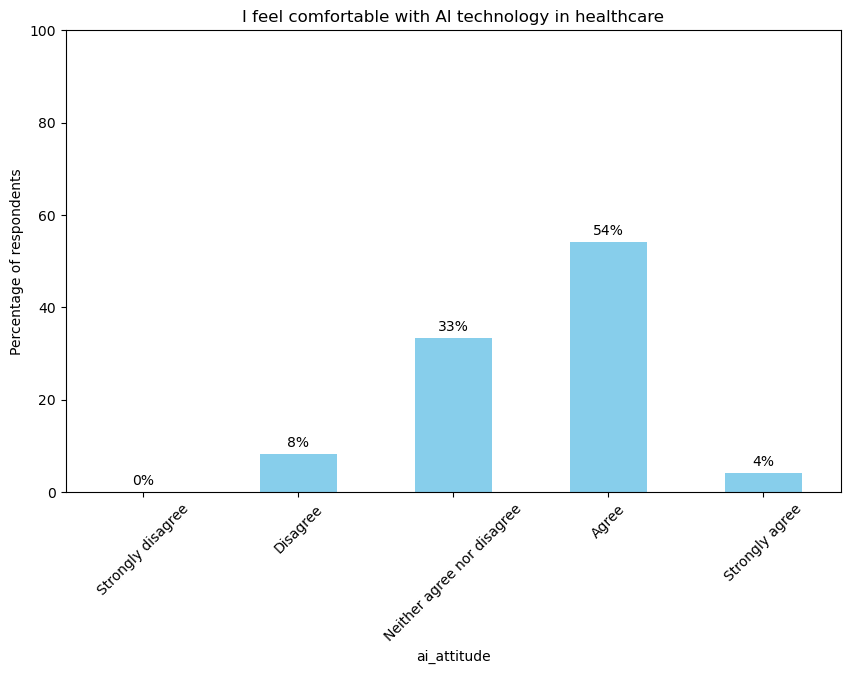

In [93]:
bar_plot(updated_tam_df[updated_tam_df['grade_new'] == 'Consultant'], 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

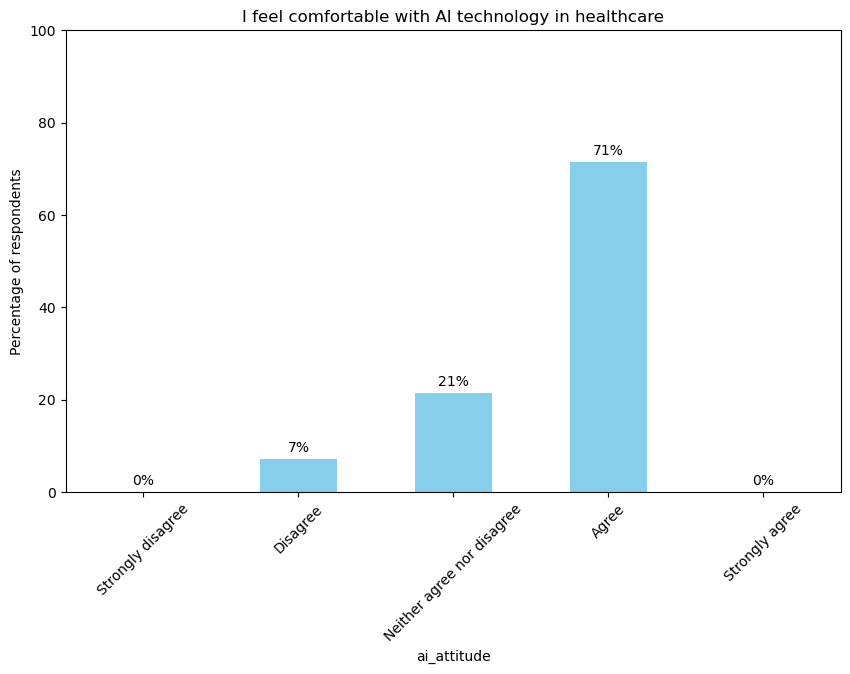

In [94]:
bar_plot(updated_tam_df[updated_tam_df['grade_new'] == 'Other'], 'ai_attitude', 'I feel comfortable with AI technology in healthcare')

In [ ]:
Plot colour coded! - slight shift to right with non consultants 

In [92]:
updated_tam_df['grade_new'].value_counts()

grade_new
Consultant    24
Other         14
Name: count, dtype: int64

In [55]:
from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro, levene

# Define the mapping of numbers to labels
labels = {'Not familiar': 1, 'Slightly familiar': 2, 'Moderately familiar': 3, 'Very familiar': 4, 'Extremely familiar': 5}

# Add new column 
updated_tam_df['ai_familiarity'] = updated_tam_df.ai_familiarity_new.map(labels)

# Shapiro-Wilk Test for normality
shapiro_familiarity_stat, shapiro_familiarity_p = shapiro(updated_tam_df['ai_familiarity'])
shapiro_comfort_stat, shapiro_comfort_p = shapiro(updated_tam_df['ai_attitude'])
print(f"Shapiro-Wilk test for familiarity_with_ai: Stat={shapiro_familiarity_stat}, p-value={shapiro_familiarity_p}")
print(f"Shapiro-Wilk test for comfort_with_ai: Stat={shapiro_comfort_stat}, p-value={shapiro_comfort_p}")

# Levene's Test for homogeneity of variances
levene_stat, levene_p = levene(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Levene's test: Stat={levene_stat}, p-value={levene_p}")

# Pearson correlation
pearson_corr, pearson_p_value = pearsonr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Pearson correlation: {pearson_corr}, p-value: {pearson_p_value}")

# Spearman correlation
spearman_corr, spearman_p_value = spearmanr(updated_tam_df['ai_familiarity'], updated_tam_df['ai_attitude'])
print(f"Spearman correlation: {spearman_corr}, p-value: {spearman_p_value}")

Shapiro-Wilk test for familiarity_with_ai: Stat=0.862240731716156, p-value=0.0002574908430688083
Shapiro-Wilk test for comfort_with_ai: Stat=0.7607860565185547, p-value=1.8232357206215966e-06
Levene's test: Stat=0.7967269595176574, p-value=0.37496725295067435
Pearson correlation: 0.18047836742675416, p-value: 0.27822594007288204
Spearman correlation: 0.182930905292443, p-value: 0.2716370031344438


Above ^^^ See not correlation between familiarity with AI and if comftable with AI indicating understanding AI is not driving force

4.394736842105263

0.4953553834402848

Shapiro test: W-statistic=0.9452548623085022, p-value=0.06216593086719513
Levene's test for user_archetype: W-statistic=0.10465116279069765, p-value=0.7481896932317053
Levene's test for age_new: W-statistic=0.39443551627159507, p-value=0.8111230528124507
Levene's test for sex_new: W-statistic=2.36554248551832, p-value=0.13278487364904665
Levene's test for medical_speciality_new: W-statistic=0.7527829976966594, p-value=0.5283910526731688
Levene's test for grade_new: W-statistic=0.12465373961218845, p-value=0.7260999786683754
Levene's test for ai_familiarity_new: W-statistic=0.8750556594532013, p-value=0.46361221533273134


anova_bool: True


Collective

Independant


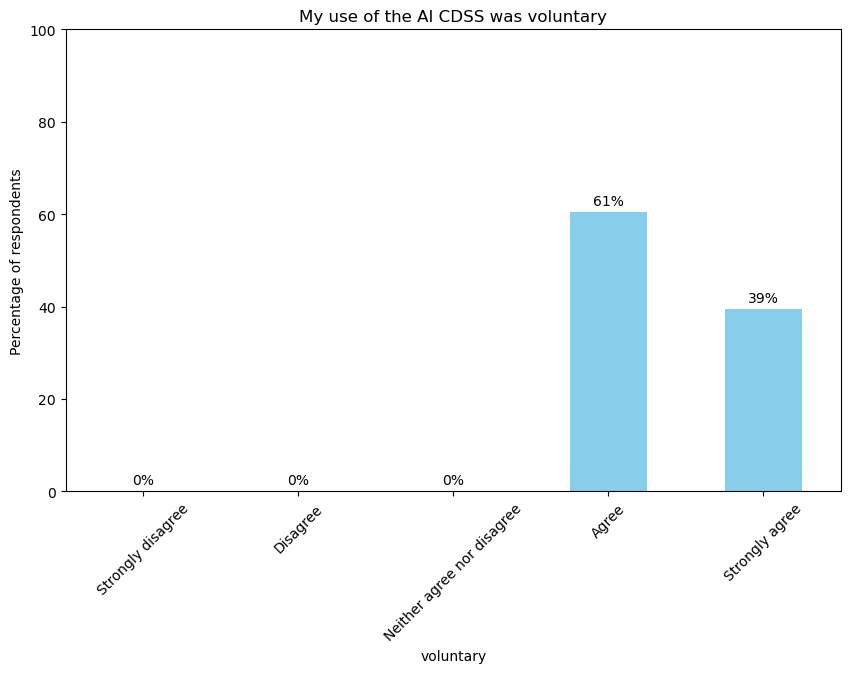

In [85]:
# voluntary
updated_tam_df['voluntary'].mean()
updated_tam_df['voluntary'].std()
anover_kw_test(updated_tam_df, 'voluntary')
bar_plot(updated_tam_df, 'voluntary', 'My use of the AI CDSS was voluntary')

3.5526315789473686

0.8604639986831941

Shapiro test: W-statistic=0.9480617046356201, p-value=0.07687318325042725
Levene's test for user_archetype: W-statistic=0.04499999999999991, p-value=0.8332005417331749
Levene's test for age_new: W-statistic=0.9292524790236459, p-value=0.4589225861836389
Levene's test for sex_new: W-statistic=0.3048286758171223, p-value=0.5842826146008688
Levene's test for medical_speciality_new: W-statistic=1.0042837154235282, p-value=0.40279709011388615
Levene's test for grade_new: W-statistic=0.05358418671112172, p-value=0.8182506289315871
Levene's test for ai_familiarity_new: W-statistic=0.20100681727775255, p-value=0.8949641985934097


anova_bool: True


Collective

Independant


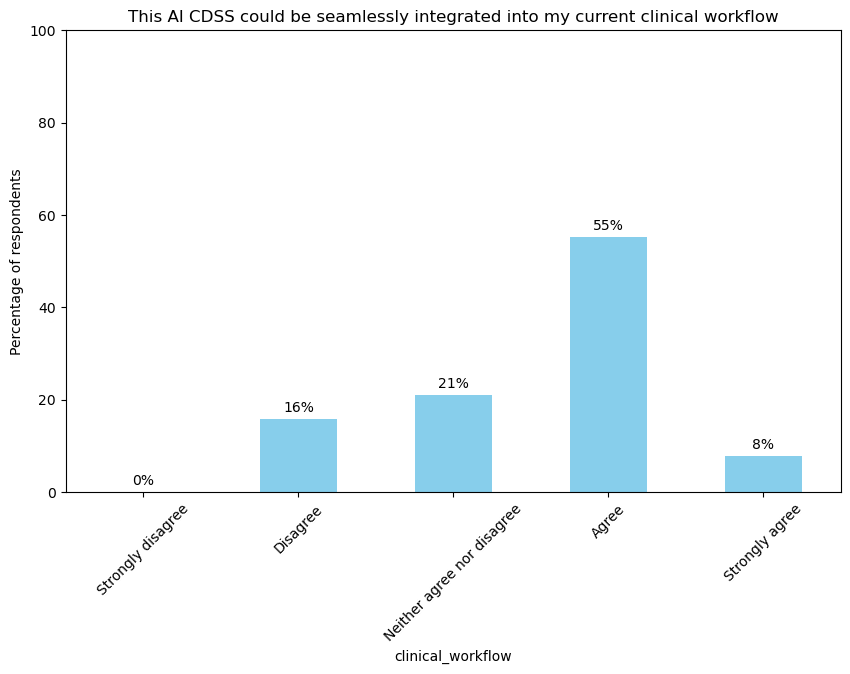

In [86]:
# clinical_workflow
updated_tam_df['clinical_workflow'].mean()
updated_tam_df['clinical_workflow'].std()
anover_kw_test(updated_tam_df, 'clinical_workflow')
bar_plot(updated_tam_df, 'clinical_workflow', 'This AI CDSS could be seamlessly integrated into my current clinical workflow')

2.789473684210526

0.8748094691970761

Shapiro test: W-statistic=0.9802914261817932, p-value=0.7278962731361389
Levene's test for user_archetype: W-statistic=0.45251396648044717, p-value=0.5054387976210216
Levene's test for age_new: W-statistic=1.5286589762076424, p-value=0.21661545726732762
Levene's test for sex_new: W-statistic=4.676434476549071, p-value=0.0372999123687929
Levene's test for medical_speciality_new: W-statistic=0.17620627412369894, p-value=0.911770725405896
Levene's test for grade_new: W-statistic=0.8509297195083517, p-value=0.36243081983349346
Levene's test for ai_familiarity_new: W-statistic=0.5964912280701754, p-value=0.6216603235679112


anova_bool: False



Independant


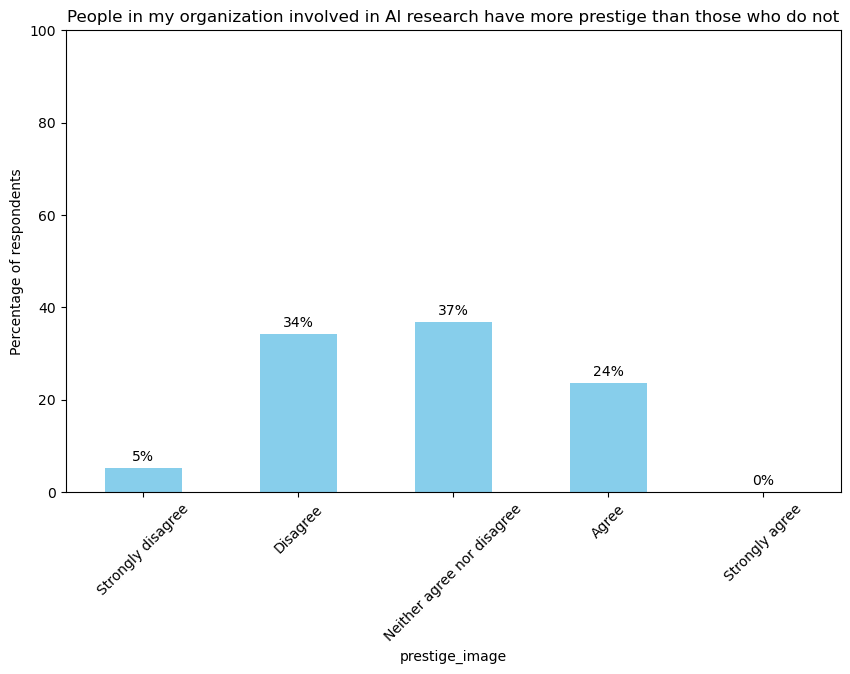

In [87]:
# prestige_image
updated_tam_df['prestige_image'].mean()
updated_tam_df['prestige_image'].std()
anover_kw_test(updated_tam_df, 'prestige_image')
bar_plot(updated_tam_df, 'prestige_image', 'People in my organization involved in AI research have more prestige than those who do not')

2.973684210526316

0.9996443179684749

Shapiro test: W-statistic=0.9834503531455994, p-value=0.834710955619812
Levene's test for user_archetype: W-statistic=1.6666666666666672, p-value=0.20493465534734007
Levene's test for age_new: W-statistic=0.6540639573617589, p-value=0.6281683868196616
Levene's test for sex_new: W-statistic=1.0327417380660946, p-value=0.3162971011669684
Levene's test for medical_speciality_new: W-statistic=0.09242670775906137, p-value=0.9637147138990685
Levene's test for grade_new: W-statistic=0.12865027172189195, p-value=0.7219306121228586
Levene's test for ai_familiarity_new: W-statistic=0.19298245614035092, p-value=0.9004489639972307


anova_bool: True


Collective
ANOVA for sex_new: Statistic=7.5600, p-value=0.0112
  -> The differences in sex_new are statistically significant.

ANOVA for medical_speciality_new: Statistic=6.0845, p-value=0.0031
  -> The differences in medical_speciality_new are statistically significant.


Independant


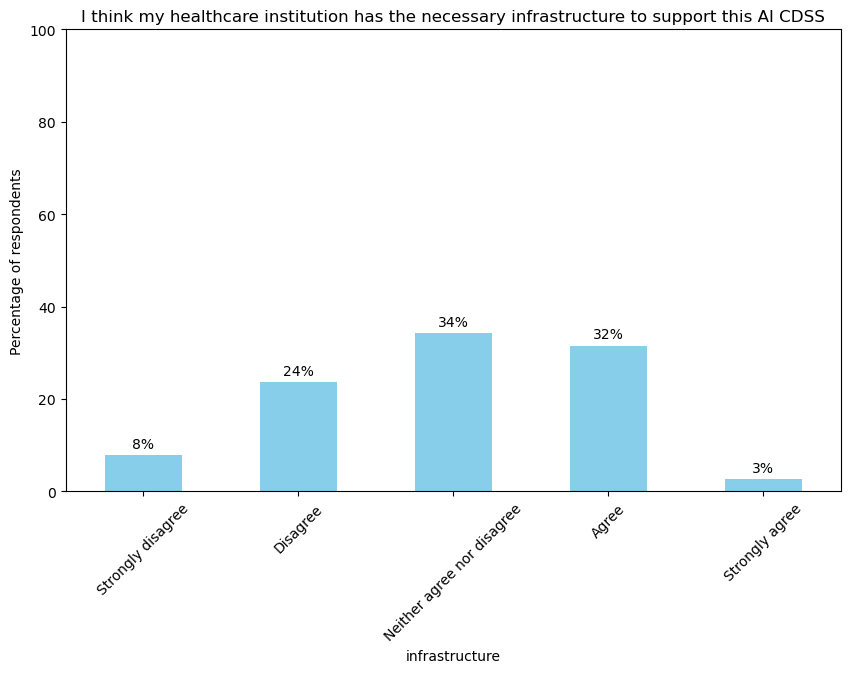

In [88]:
# infrastructure
updated_tam_df['infrastructure'].mean()
updated_tam_df['infrastructure'].std()
anover_kw_test(updated_tam_df, 'infrastructure')
bar_plot(updated_tam_df, 'infrastructure', 'I think my healthcare institution has the necessary infrastructure to support this AI CDSS')

3.763157894736842

0.7141129642758207

Shapiro test: W-statistic=0.9426068663597107, p-value=0.05092615261673927
Levene's test for user_archetype: W-statistic=0.06293706293706294, p-value=0.803338999372528
Levene's test for age_new: W-statistic=0.3938188494492044, p-value=0.8115579211965215
Levene's test for sex_new: W-statistic=3.8754385964912257, p-value=0.056734109607818044
Levene's test for medical_speciality_new: W-statistic=0.318812029577271, p-value=0.8116787269320628
Levene's test for grade_new: W-statistic=0.640206381763972, p-value=0.4288846878322897
Levene's test for ai_familiarity_new: W-statistic=0.7298245614035088, p-value=0.5413590910331962


anova_bool: True


Collective

Independant


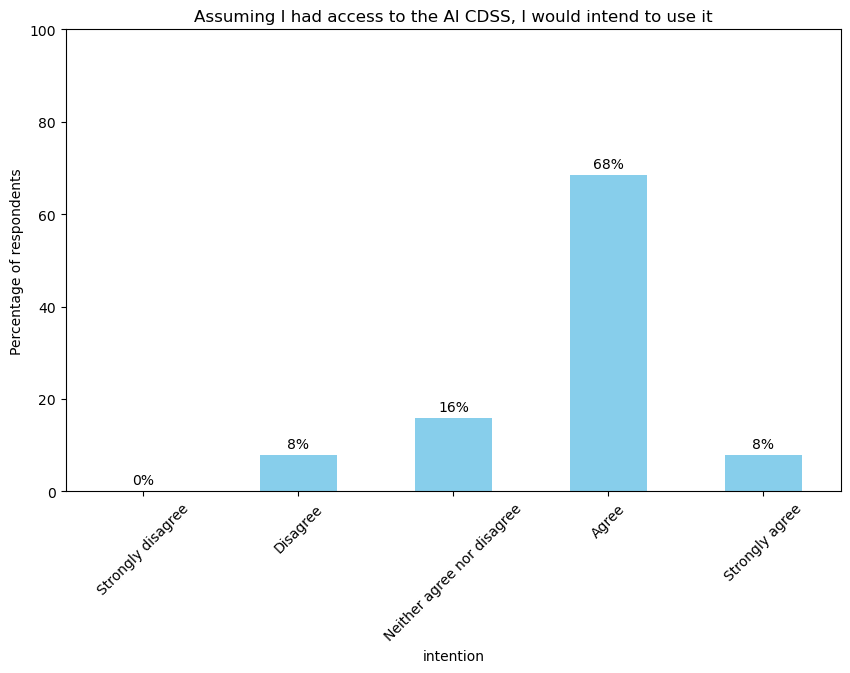

In [89]:
# intention
updated_tam_df['intention'].mean()
updated_tam_df['intention'].std()
anover_kw_test(updated_tam_df, 'intention')
bar_plot(updated_tam_df, 'intention', 'Assuming I had access to the AI CDSS, I would intend to use it')

3.0526315789473686

0.6554292350964069

Shapiro test: W-statistic=0.974374532699585, p-value=0.5222071409225464
Levene's test for user_archetype: W-statistic=0.41379310344827575, p-value=0.5241272128823635
Levene's test for age_new: W-statistic=2.557017543859649, p-value=0.057002717699554215
Levene's test for sex_new: W-statistic=1.4607002086714587, p-value=0.23469759406568608
Levene's test for medical_speciality_new: W-statistic=0.7804342581565705, p-value=0.5131112928772308
Levene's test for grade_new: W-statistic=0.004870788797185732, p-value=0.94474622597965
Levene's test for ai_familiarity_new: W-statistic=0.7028718292546654, p-value=0.5569087148290551


anova_bool: True


Collective

Independant


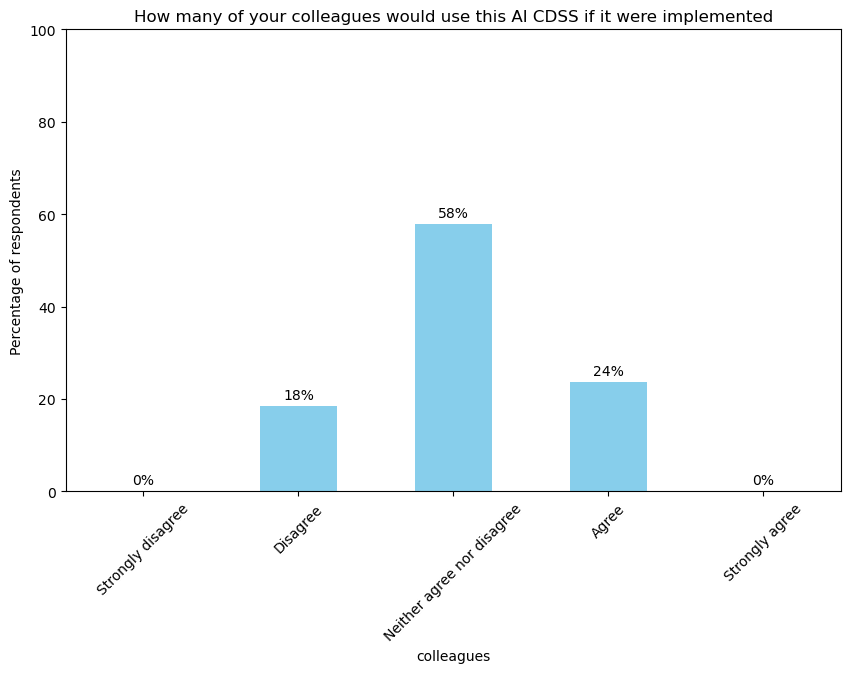

In [90]:
# prestige_image
updated_tam_df['colleagues'].mean()
updated_tam_df['colleagues'].std()
anover_kw_test(updated_tam_df, 'colleagues')
bar_plot(updated_tam_df, 'colleagues', 'How many of your colleagues would use this AI CDSS if it were implemented')

# Old

In [47]:
mardia_test = pg.multivariate_normality(pu_df, alpha=0.05)
print(mardia_test)

HZResults(hz=0.9957092836013285, pval=0.029661972701394965, normal=False)


In [37]:
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='age')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='sex_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='medical_speciality_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='grade_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='ai_familiarity_new')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,1638.0,NaN,False


,Chi2,df,pval,equal_cov
box,75.593733,78.0,0.556115,True


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,78.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


In [27]:
formula

'PU1+PU2+PU3+PU4+PU5+PU6+PU7+PU8+PU9+PU10+PU11+PU12 ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

In [26]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [29]:
print(result)


                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.1534 12.0000 5.0000  2.2992 0.1841
           Pillai's trace 0.8466 12.0000 5.0000  2.2992 0.1841
   Hotelling-Lawley trace 5.5182 12.0000 5.0000  2.2992 0.1841
      Roy's greatest root 5.5182 12.0000 5.0000  2.2992 0.1841
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2781 12.0000 5.0000  1.0816 0.5018
           Pillai's trace 0.7219 12.0000 5.0000  1.0816 0.5018
   Hotellin

In [38]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.rank().join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [39]:
print(result)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2193 12.0000 5.0000  1.4837 0.3489
           Pillai's trace 0.7807 12.0000 5.0000  1.4837 0.3489
   Hotelling-Lawley trace 3.5609 12.0000 5.0000  1.4837 0.3489
      Roy's greatest root 3.5609 12.0000 5.0000  1.4837 0.3489
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4661 12.0000 5.0000  0.4774 0.8635
           Pillai's trace 0.5339 12.0000 5.0000  0.4774 0.8635
   Hotellin